*Bojan Kostic [boko@dtu.dk]*

Machine Learning for Smart Mobility ([MLSM](http://mlsm.man.dtu.dk/)) Group  
Transport Division  
DTU Management

Notebook adapted from: https://square.github.io/pysurvival/tutorials/maintenance.html

# Introduction to Business Analytics <span style="color:#3498DB">/</span> Data Science for Mobility

## **<span style="color:red">Survival Analysis</span>**

---

## *Predictive maintenance - predicting when a machine will break*

---

## <span style="color:#3498DB">1. Introduction</span>

[Predictive maintenance](https://en.wikipedia.org/wiki/Predictive_maintenance) (PdM) is a great application of survival analysis since it consists in predicting when equipment failure will occur and therefore alerting the maintenance team to prevent that failure. Indeed, accurately modeling if and when a machine will break is crucial for industrial and manufacturing businesses as it can help:

* maintain a safe work environment by ensuring that machines are working properly;
* increase productivity by preventing unplanned reactive maintenance and minimizing downtime;
* optimize costs by removing the need for too many unnecessary checks or repairs of components - a.k.a preventative maintenance.

Within the past couple of years, thanks to the use of [Internet of Things (IoT) technologies](https://en.wikipedia.org/wiki/Internet_of_things#Manufacturing), a plethora of data has been generated by various sensors on machines, mechanical and electrical components, such as temperature, vibration, voltage or pressure. This type of information can be used to predict future failures.

---

## <span style="color:#3498DB">2. Setup</span>

We will consider that a manufacturing company uses many machines to build their final products. The factory is using IoT technologies via smart sensors to measure and save various kinds of inputs from the physical environment and the state of their equipment.

Unfortunately, every time a machine breaks the production is stopped, which costs the company thousands of dollars in repair and late delivery fees. The factory manager asks the company Data Science team if it is possible to find a way to be more pro-active so as to optimize spending.

Let's start by importing all the necessary modules.

In [1]:
# Import modules
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('text', usetex=True)

import seaborn as sns
import bokeh
from bokeh.palettes import Category10

import lifelines
import sklearn

import pickle

In [2]:
# Libraries' versions used
print('NumPy {}'.format(np.__version__))
print('pandas {}'.format(pd.__version__))
print('matplotlib {}'.format(matplotlib.__version__))
print('seaborn {}'.format(sns.__version__))
print('bokeh {}'.format(bokeh.__version__))
print('lifelines {}'.format(lifelines.__version__))
print('scikit-learn {}'.format(sklearn.__version__))

NumPy 1.16.5
pandas 0.25.2
matplotlib 3.1.1
seaborn 0.9.0
bokeh 1.3.4
lifelines 0.22.10
scikit-learn 0.21.3


In [3]:
# Define colors
colors = []
for i in range(5):
    colors.append(Category10[10][i])

---

## <span style="color:#3498DB">3. Dataset</span>

The dataset the team wants to use contains the following features:

<img src="dataset_maintenance.png" width=600>

### 3.1. Dataset overview

In [4]:
# Load the dataset
raw_dataset = pd.read_csv(
    'maintenance_data.csv',
    sep=';',
)

In [5]:
# Print dataset size
print('The raw_dataset has the following shape: {}'.format(raw_dataset.shape))
print('{:<16} {}'.format('No. of samples:', raw_dataset.shape[0]))
print('{:<16} {}'.format('No. of features:', raw_dataset.shape[1]))

The raw_dataset has the following shape: (1000, 7)
No. of samples:  1000
No. of features: 7


It's time to inspect the dataset. There are several very useful commands to get a basic idea about the dataset, summary statistics or to assess the type of variables we're dealing with, such as `head()`, `info()` or `describe()`. Use them. What does it tell you about the dataset?

In [6]:
raw_dataset.head()

,lifetime,broken,pressureInd,moistureInd,temperatureInd,team,provider
0,56,0,92.178854,104.230204,96.517159,TeamA,Provider4
1,81,1,72.075938,103.065701,87.271062,TeamC,Provider4
2,60,0,96.272254,77.801376,112.196170,TeamA,Provider1
3,86,1,94.406461,108.493608,72.025374,TeamC,Provider2
4,34,0,97.752899,99.413492,103.756271,TeamB,Provider1


In [7]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
lifetime          1000 non-null int64
broken            1000 non-null int64
pressureInd       1000 non-null float64
moistureInd       1000 non-null float64
temperatureInd    1000 non-null float64
team              1000 non-null object
provider          1000 non-null object
dtypes: float64(3), int64(2), object(2)
memory usage: 54.8+ KB


In [8]:
raw_dataset.describe()

,lifetime,broken,pressureInd,moistureInd,temperatureInd
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,55.195000,0.397000,98.599338,99.376723,100.628541
std,26.472737,0.489521,19.964052,9.988726,19.633060
min,1.000000,0.000000,33.481917,58.547301,42.279598
25%,34.000000,0.000000,85.558076,92.771764,87.676913
50%,60.000000,0.000000,97.216997,99.433959,100.592277
75%,80.000000,1.000000,112.253190,106.120762,113.662885
max,93.000000,1.000000,173.282541,128.595038,172.544140


### 3.2. Features and labels

As we can see from running the `info()` command, there are 7 columns in the dataset: 5 feature columns and 2 label columns.

#### 3.2.1. Labels/dependent variables: time-to-event (TTE) and event indicator

The first thing we need to do in survival analysis is to define variables describing survival times ($ T $) and censorship indication ($ E $), which are:

* `lifetime`
* `broken`

As we are using DataFrame structure, let's just define column names storing these data and call them `time_column` and `event_column`. As it can be see from the previous table, *time* is stored in the *lifetime* column and *event* is stored in the *broken* column.

In [9]:
# Define the time and event columns
time_column = 'lifetime'
event_column = 'broken'

#### 3.2.2. Features/independent variables: numerical and categorical

There are 3 numerical features:

* `pressureInd`
* `moistureInd`
* `temperatureInd`

and 2 categorical features:

* `team`
* `provider`

in our dataset. Let's do the following:

* define a list of numerical features, storing it in the `num_features` variable, and a list of categorical features, storing it in the `cat_features` variable;
* cast categorical features from *string* (*object*) to *category* data type;
* encode the categorical variables as one-hot vectors using pandas `get_dummies` method (set `drop_first` argument to `True`), storing it in the `dataset` variable;
* define a list of the modeling features as `features`.

In [10]:
# Numerical features
num_features = [
    'pressureInd',
    'moistureInd',
    'temperatureInd',
]

# Categorical features
cat_features = [
    'provider',
    'team',
]

In [11]:
# Cast categorical features from 'string' to 'category' data type
for col in cat_features:
    raw_dataset[col] = raw_dataset[col].astype('category')

In [12]:
# Encode the categorical variables as one-hot vectors
dataset = pd.get_dummies(
    raw_dataset,
    columns=cat_features,
    drop_first=True,
)

In [13]:
# Define a list of the modelling features
features = np.setdiff1d(dataset.columns, [time_column, event_column]).tolist()
features

['moistureInd',
 'pressureInd',
 'provider_Provider2',
 'provider_Provider3',
 'provider_Provider4',
 'team_TeamB',
 'team_TeamC',
 'temperatureInd']

Compare datasets before and after one-hot encoding.

In [14]:
raw_dataset.head()

,lifetime,broken,pressureInd,moistureInd,temperatureInd,team,provider
0,56,0,92.178854,104.230204,96.517159,TeamA,Provider4
1,81,1,72.075938,103.065701,87.271062,TeamC,Provider4
2,60,0,96.272254,77.801376,112.196170,TeamA,Provider1
3,86,1,94.406461,108.493608,72.025374,TeamC,Provider2
4,34,0,97.752899,99.413492,103.756271,TeamB,Provider1


In [15]:
dataset.head()

,lifetime,broken,pressureInd,moistureInd,temperatureInd,provider_Provider2,provider_Provider3,provider_Provider4,team_TeamB,team_TeamC
0,56,0,92.178854,104.230204,96.517159,0,0,1,0,0
1,81,1,72.075938,103.065701,87.271062,0,0,1,0,1
2,60,0,96.272254,77.801376,112.196170,0,0,0,0,0
3,86,1,94.406461,108.493608,72.025374,1,0,0,0,1
4,34,0,97.752899,99.413492,103.756271,0,0,0,1,0


What would happen if `drop_first` was set to `False`?

In [16]:
pd.get_dummies(
    raw_dataset,
    columns=cat_features,
    drop_first=True,
)

,lifetime,broken,pressureInd,moistureInd,temperatureInd,provider_Provider2,provider_Provider3,provider_Provider4,team_TeamB,team_TeamC
0,56,0,92.178854,104.230204,96.517159,0,0,1,0,0
1,81,1,72.075938,103.065701,87.271062,0,0,1,0,1
2,60,0,96.272254,77.801376,112.196170,0,0,0,0,0
3,86,1,94.406461,108.493608,72.025374,1,0,0,0,1
4,34,0,97.752899,99.413492,103.756271,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
995,88,1,88.589759,112.167556,99.861456,0,0,1,1,0
996,88,1,116.727075,110.871332,95.075631,0,0,1,0,0
997,22,0,104.026778,88.212873,83.221220,0,0,0,1,0
998,78,0,104.911649,104.257296,83.421491,0,0,1,0,0


In [17]:
pd.get_dummies(
    raw_dataset,
    columns=cat_features,
    drop_first=False,
)

,lifetime,broken,pressureInd,moistureInd,temperatureInd,provider_Provider1,provider_Provider2,provider_Provider3,provider_Provider4,team_TeamA,team_TeamB,team_TeamC
0,56,0,92.178854,104.230204,96.517159,0,0,0,1,1,0,0
1,81,1,72.075938,103.065701,87.271062,0,0,0,1,0,0,1
2,60,0,96.272254,77.801376,112.196170,1,0,0,0,1,0,0
3,86,1,94.406461,108.493608,72.025374,0,1,0,0,0,0,1
4,34,0,97.752899,99.413492,103.756271,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,88,1,88.589759,112.167556,99.861456,0,0,0,1,0,1,0
996,88,1,116.727075,110.871332,95.075631,0,0,0,1,1,0,0
997,22,0,104.026778,88.212873,83.221220,1,0,0,0,0,1,0
998,78,0,104.911649,104.257296,83.421491,0,0,0,1,1,0,0


---

## <span style="color:#3498DB">4. Exploratory data analysis</span>

Let's perform an exploratory data analysis (EDA), so as to understand what the data look like and start answering interesting questions about our problem.

### 4.1. Null values and duplicates

The first thing to do is checking if the `dataset` contains `Null` values and has duplicated rows.

For `Null` values, you can use pandas `isnull()` method: *This function takes a scalar or array-like object and indicates whether values are missing (`NaN` in numeric arrays, `None` or `NaN` in object arrays, `NaT` in datetimelike)* (from pandas documentation).

For duplicates, calculate the number of duplicated samples and remove duplicates. You can use `duplicated` and `drop_duplicates` methods.

In the end, calculate the number of samples in the dataset, and store it in `N`.

In [18]:
dataset[features].isnull().sum()

moistureInd           0
pressureInd           0
provider_Provider2    0
provider_Provider3    0
provider_Provider4    0
team_TeamB            0
team_TeamC            0
temperatureInd        0
dtype: int64

In [19]:
# Check for Null values
N_null = sum(dataset[features].isnull().sum())
print('The dataset contains {} Null values.'.format(N_null))

The dataset contains 0 Null values.


In [20]:
# Remove duplicates, if any
N_dupli = sum(dataset.duplicated(keep='first'))
dataset = dataset.drop_duplicates(keep='first').reset_index(drop=True)
print('The dataset contains {} duplicates.'.format(N_dupli))

The dataset contains 0 duplicates.


In [21]:
# Number of samples in the dataset
N = dataset.shape[0]
N

1000

As it turns out, the dataset doesn't have any `Null` values or duplicates.

### 4.2. Visual exploration and statistics

Let's check out/visualize the feature statistics.

#### 4.2.1. Numerical features

We will display the [boxplot](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51) and histogram for each numerical feature.

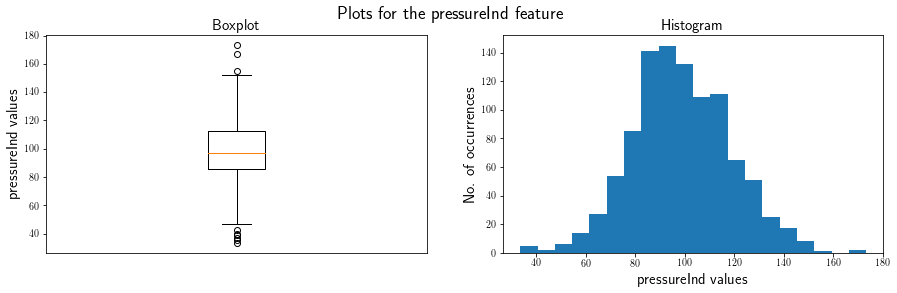

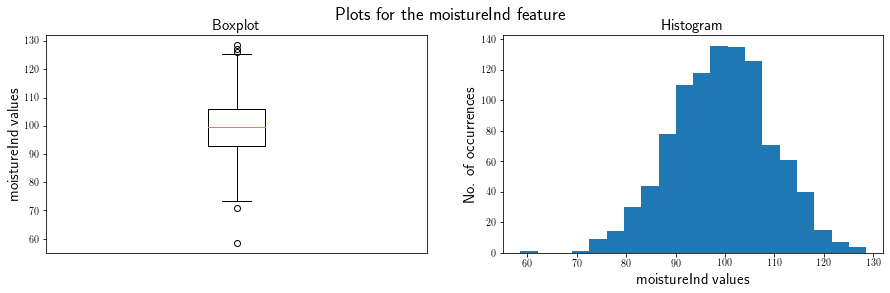

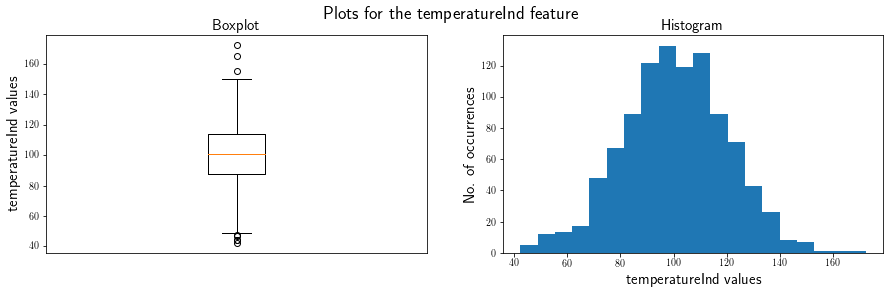

In [22]:
# For each numerical feature
for feature in num_features:
    
    # Initialize the figure
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15., 4.))
    
    fig.suptitle(
        'Plots for the {} feature'.format(feature),
        fontsize=18.,
    )
    
    # Extract the feature values
    x = dataset[feature].to_numpy()
    
    # Boxplot
    ax1.boxplot(x)
    ax1.set_title(
        'Boxplot',
        fontsize=15.,
    )
    ax1.set_xlabel('')
    ax1.set_xticks([])
    ax1.set_ylabel(
        '{} values'.format(feature),
        fontsize=15.,
    )
    
    # Histogram
    ax2.hist(
        x,
        bins=20,
        color=colors[0],
    )
    ax2.set_title(
        'Histogram',
        fontsize=15.,
    )
    ax2.set_xlabel(
        '{} values'.format(feature),
        fontsize=15.,
    )
    ax2.set_ylabel(
        'No. of occurrences',
        fontsize=15.,
    )
    
    # Display
    plt.show()

These features have very few outliers, so there's no real need to remove them (*here, there's no real need to remove them, but you can if you prefer*), and they seem to follow normal distributions.

#### 4.2.2. Categorical features

We will display the occurrences of the categories in a barchart for each feature.

In [23]:
from collections import Counter

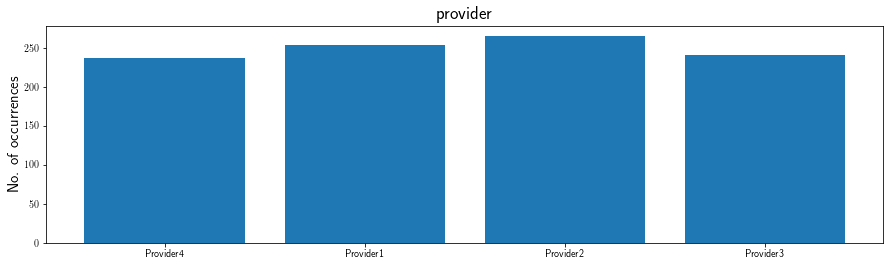

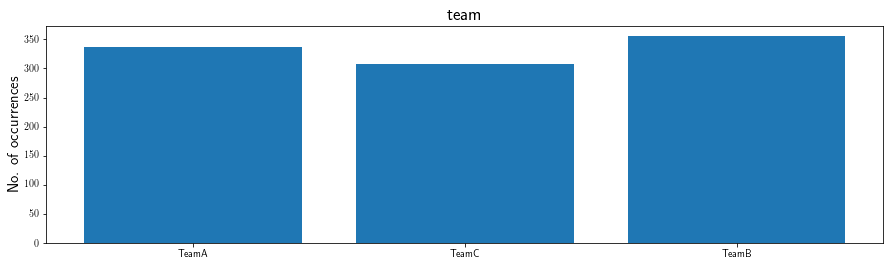

In [24]:
# For each categorical feature
for feature in cat_features:
    
    # Initialize the figure
    fig, ax = plt.subplots(figsize=(15., 4.))
    
    # Extract the feature values
    x = raw_dataset[feature].to_numpy()
    
    # Count the number of occurrences for each category
    data = Counter(x)
    category = list(data.keys())
    counts = list(data.values())
    
    # Barchart
    ax.bar(
        category,
        counts,
        color=colors[0],
    )
    ax.set_title(
        feature,
        fontsize=18.,
    )
    ax.set_ylabel(
        'No. of occurrences',
        fontsize=15.,
    )
    
    # Display
    plt.show()

These features seem to be uniformly distributed. Otherwise, if is good to do some downsampling/upsampling to balance the dataset.

#### 4.2.3. Time & Event

We will display the occurrences of event and censorship, as well as the distribution of the time output variable for both situations.

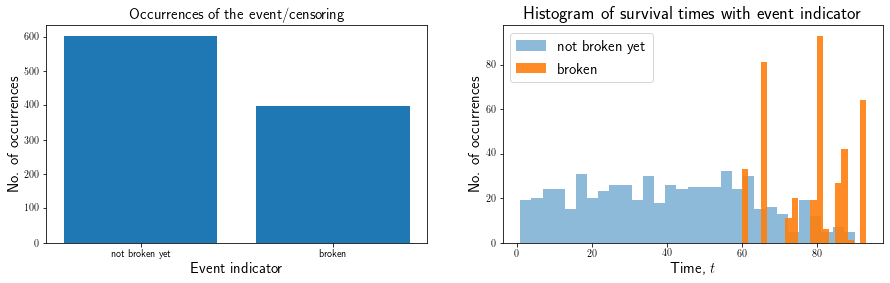

In [25]:
# Initialize the figure
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15., 4.))

# Define labels
label_broken = 'broken'
label_not_broken = 'not broken yet'

# Count the number of occurrences for each category 
data = Counter(raw_dataset[event_column].replace({
    0: label_not_broken,
    1: label_broken
}))

category, counts = list(data.keys()), list(data.values())

idx = range(len(counts))

# Display the occurrences of the event/censoring
ax1.bar(
    idx,
    counts,
    color=colors[0],
)
ax1.set_xticks(idx)
ax1.set_xticklabels(category)
ax1.set_title(
    'Occurrences of the event/censoring',
    fontsize=15.,
)
ax1.set_xlabel(
    'Event indicator',
    fontsize=15.,
)
ax1.set_ylabel(
    'No. of occurrences',
    fontsize=15.,
)

# Show the histogram of the survival times for the censoring
time_0 = raw_dataset.loc[raw_dataset[event_column] == 0, time_column]

# Histogram 1
ax2.hist(
    time_0,
    bins=30,
    alpha=.5,
    color=colors[0],
    label=label_not_broken,
)

# Showing the histogram of the survival times for the events
time_1 = raw_dataset.loc[raw_dataset[event_column] == 1, time_column]

# Histogram 2
ax2.hist(
    time_1,
    bins=20,
    alpha=.9,
    color=colors[1],
    label=label_broken,
)
ax2.set_title(
    'Histogram of survival times with event indicator',
    fontsize=18.,
)
ax2.set_xlabel(
    'Time, $ t $',
    fontsize=15.,
)
ax2.set_ylabel(
    'No. of occurrences',
    fontsize=15.,
)
ax2.legend(fontsize=15.)

# Display everything side-by-side
plt.show()

Here, we can see that 2/3 of the data is censored and that the failures start happening when the machine has been active for at least 60 weeks.

### 4.3. Correlations

Let's compute and visualize the correlation between the features. We can use `corr()` pandas DataFrame method and seaborn `heatmap()` plotting function. 

In [26]:
# Calculate correlations
corr = dataset[features].corr()
corr

,moistureInd,pressureInd,provider_Provider2,provider_Provider3,provider_Provider4,team_TeamB,team_TeamC,temperatureInd
moistureInd,1.000000,0.020543,-0.017177,-0.049209,0.064055,-0.004941,0.022036,-0.009842
pressureInd,0.020543,1.000000,-0.005777,-0.025734,0.015483,-0.076048,-0.020955,0.003641
provider_Provider2,-0.017177,-0.005777,1.000000,-0.340146,-0.336437,-0.012743,0.019961,0.034862
provider_Provider3,-0.049209,-0.025734,-0.340146,1.000000,-0.315780,0.018764,-0.027998,-0.017943
provider_Provider4,0.064055,0.015483,-0.336437,-0.315780,1.000000,-0.042804,0.034058,-0.009432
team_TeamB,-0.004941,-0.076048,-0.012743,0.018764,-0.042804,1.000000,-0.496026,-0.012056
team_TeamC,0.022036,-0.020955,0.019961,-0.027998,0.034058,-0.496026,1.000000,0.012601
temperatureInd,-0.009842,0.003641,0.034862,-0.017943,-0.009432,-0.012056,0.012601,1.000000


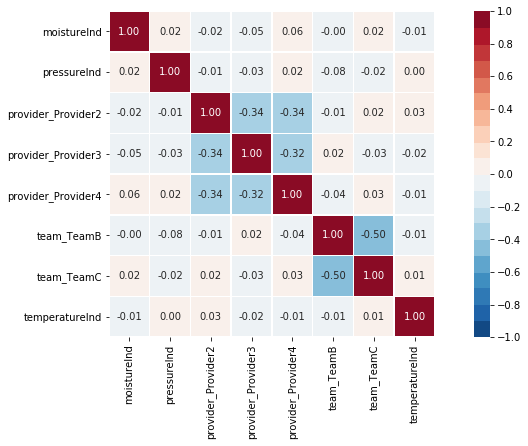

In [27]:
# Plot correlation matrix
plt.rc('text', usetex=False)

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(14., 6.))

# Generate a custom diverging colormap
cmap = sns.color_palette('RdBu_r', 20)

# Draw the heatmap
sns.heatmap(
    corr,
    cmap=cmap,
    annot=True,
    fmt='.2f',
    vmax=1.,
    vmin=-1.,
    center=0.,
    square=True,
    linewidths=.5,
    cbar_kws={
        'shrink': 1.,
        'ticks': np.arange(-1., 1.1, .2),
    },
)

# Fix for matplotlib bug that cuts off top/bottom of seaborn viz
plt.ylim(
    plt.ylim()[0] + .5,
    plt.ylim()[1] - .5,
)

# Display
plt.show()

What do these correlations tell us? As we can see, there aren't any alarming correlations, so we will not remove any feature.

---

## <span style="color:#3498DB">5. Preparation</span>

### 5.1. Splitting between training and test data

To assess the performances of the model, let's split the dataset into training and testing sets. Let's define ``data_train`` and ``data_train``, using 30% of the data as test data.

In [28]:
# Build training and test sets
from sklearn.model_selection import train_test_split

index_train, index_test = train_test_split(
    range(N),
    test_size=.3,
)

data_train = dataset.loc[index_train]
data_test = dataset.loc[index_test]

### 5.2. Standardizing the data

Let's standardize the data! We can use [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) from `scikit-learn`. We need to fit the scaler on the training data only, and then to transform both training and test data.

In [29]:
# Import scaler
from sklearn.preprocessing import StandardScaler

In [30]:
# Initialize the scaler
scaler = StandardScaler()

In [31]:
# Fit the scaler to training data features
scaler.fit(data_train[features])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [32]:
# Transform the training and test data
data_train[features] = scaler.transform(data_train[features])
data_test[features] = scaler.transform(data_test[features])

We need to define `X`, `T` and `E` for training and test data.

In [33]:
# Creating the X, T and E inputs for train and test sets
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

### 5.3. Performance metrics

In order to assess the model performance, we previously split the original dataset into training and test sets, so that we can compute its performance metrics on the test set.

#### 5.3.1. Concordance index (C-index)

The [concordance index (C-index)](https://lifelines.readthedocs.io/en/latest/lifelines.utils.html#lifelines.utils.concordance_index) represents the global assessment of the model discrimination power: ***this is the model’s ability to correctly provide a reliable ranking of the survival times based on the individual risk scores***. In general, when the C-index is close to 1, the model has an almost perfect discriminatory power; but when it is close to 0.5, it has no ability to discriminate between low and high risk subjects. It is formulated as:

$$ C = \frac{1}{\vert \epsilon \vert} \sum_{i: E_i = 1} \sum_{j: T_j \ge T_i} \mathbf{1}_{f(\mathrm{\mathbf{x}}_i) < f(\mathrm{\mathbf{x}}_j)} $$

where $ \epsilon $ is the number of samples and $ \mathbf{1} $ is the indicator function with binary outcome based on the condition.

`lifelines` has the `concordance_index` method implemented.

In [34]:
# Import concordance_index
from lifelines.utils import concordance_index

#### 5.3.2. Brier score

The [Brier score (BS)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html) ***measures the average discrepancies between the status and the estimated probabilities at a given time***. Thus, the lower the score (usually **below 0.25**), the better the predictive performance. To assess the overall error measure across multiple time points, the Integrated Brier Score (IBS) is usually computed as well. It is formulated as:

$$ \mathit{BS}(t) = \frac{1}{N} \sum_{i = 1}^{N} {\left( 1_{T_i > t} - \hat{S} \left( t, \mathrm{\mathbf{x}}_i \right) \right)}^2 $$

The Integrated Brier Score (IBS) provides an overall calculation of the model performance at all available times:

$$ \mathit{IBS}(T_{max}) = \frac{1}{T_{max}} \sum_{i = 0}^{T_{max}} BS(t) $$

`scikit-learn` has the `brier_score_loss` method implemented.

In [35]:
# Import brier_score_loss
from sklearn.metrics import brier_score_loss

---

## <span style="color:#3498DB">6. Modelling</span>

<div style="background-color:lightblue">
Let's now fit and validate several survival models, and compare their predictive capacity. Let's do the following steps for every model:

* Import the model
* Initialize the model
* Check feature scaling in the model
* Fit the model
* Check the model
* Validate the model - calculate C-index and IBS for training and test sets

We will try out the following models:

* **Kaplan-Meier** (KM) model
* **Nelson-Aalen** (NA) model
* **Cox Proportional Hazards** (CPH) model

We will use the [`lifelines`](https://lifelines.readthedocs.io/en/latest) library. To test some machine learning models (such as **Survival Support Vector Machines**, **Random Survival Forests**, **DeepSurv**, etc.), you can use the [`pysurvival`](https://square.github.io/pysurvival) library (beware that it may be difficult to install it, especially on Windows machines, and it may not work).
</div>

The estimation of the survival and cumulative hazard functions using population-level dataset can be done using non-parametric univariate models. Survival and cumulative hazard functions are functions of survival times with event indicator, i.e. $ S(t) = f(\mathrm{\mathbf{T}}, \mathrm{\mathbf{E}}) $ and $ H(t) = g(\mathrm{\mathbf{T}}, \mathrm{\mathbf{E}}) $. Given the ordered survival times, for each instant of interest on the timeline the number of individuals at risk and the number of death events occurring is determined. The survival function is usually estimated using the **Kaplan-Meier** method, a product-limit estimator. It takes as input survival times and estimates the survival function as:

$$ \hat{S}(t) = \prod_{i: t_i \le t} \left( 1 - \frac{d_i}{n_i} \right) $$

where $ d_i $ is the number of death events at time $ t $ and $ n_i $ is the number of individuals at risk of death just prior and at time $ t $. Similarly, the cumulative hazard function can be estimated using the **Nelson-Aalen** method as:

$$ \hat{H}(t) = \sum_{i: t_i \leq t} \frac{d_i}{n_i} $$

Hazard and cumulative hazard values cannot be directly interpreted, but are used for relative comparison among themselves in discovering which timeline instants are more likely to encounter a death event than others.

Univariate non-parametric survival models are simple and can provide flexible survival and hazard curves. They provide population-level insight into survival behaviour, but not at the individual level.

### 6.1a [Kaplan-Meier](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator) model

Let's now fit a Kaplan-Meier model to the complete dataset. This will give us population-based average survival behaviour that we can later use to compare with more advanced models.

Let's start by importing the `KaplanMeierFitter` estimator from the `lifelines` library.

In [36]:
# Import estimator
from lifelines import KaplanMeierFitter

In [37]:
# Initialize the Kaplan-Meier model
km = KaplanMeierFitter()

In [38]:
# Fit the model
km.fit(
    dataset[time_column],
    event_observed=dataset[event_column],
)

<lifelines.KaplanMeierFitter: fitted with 1000 total observations, 603 right-censored observations>

We can have access to all the number of observations for the timeline through `event_table` attribute.

In [39]:
# Check event table
km.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,1000,1000
1.0,5,0,5,0,1000
2.0,11,0,11,0,995
3.0,3,0,3,0,984
4.0,8,0,8,0,981
...,...,...,...,...,...
88.0,46,42,4,0,112
89.0,1,1,0,0,66
90.0,1,0,1,0,65


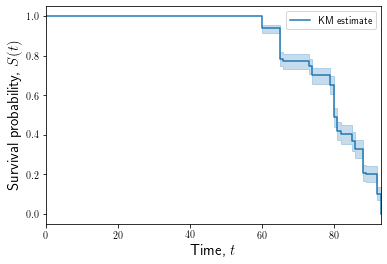

In [40]:
# Plot KM estimate of the survival function
plt.rc('text', usetex=True)

# Display survival function
ax = km.plot(label='KM estimate')
ax.set_xlabel(
    'Time, $ t $',
    fontsize=15.,
)
ax.set_ylabel(
    'Survival probability, $ S(t) $',
    fontsize=15.,
)
plt.legend()
plt.show()

We can access the CDF, $ F(t) $, using `cumulative_density_` attribute. Let's also plot it.

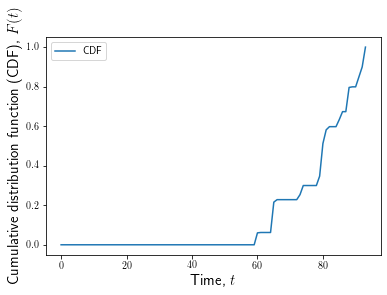

In [41]:
# Calculate cumulative distribution function (CDF), denoted by F
F = km.cumulative_density_.to_numpy().flatten()

# Plot CDF
plt.plot(
    km.timeline,
    F,
    color=colors[0],
    label='CDF',
)
plt.xlabel(
    'Time, $ t $',
    fontsize=15.,
)
plt.ylabel(
    'Cumulative distribution function (CDF), $ F(t) $',
    fontsize=15.,
)
plt.legend()
plt.show()

We can calculate the PDF, $ f(t) $, using the CDF. Let's also plot it.

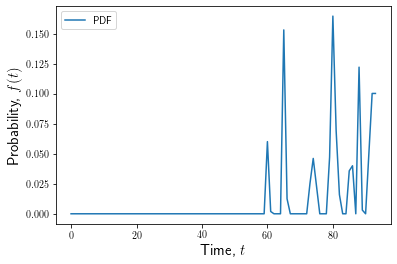

In [42]:
# Plot probability density dunction (PDF), denoted by f
f = F.copy()
f[1:] -= f[:-1]

plt.plot(
    km.timeline,
    f,
    color=colors[0],
    label='PDF',
)
plt.xlabel(
    'Time, $ t $',
    fontsize=15.,
)
plt.ylabel(
    'Probability, $ f(t) $',
    fontsize=15.,
)
plt.legend()
plt.show()

We saw what the survival function looks like and when we can expect the machines will break. But is there any difference between the machines, e.g. regarding different providers? Can you fit Kaplan-Meier model for each provider separately and plot them together? Is there any difference between survival functions? We can do it also for each team at the same time.

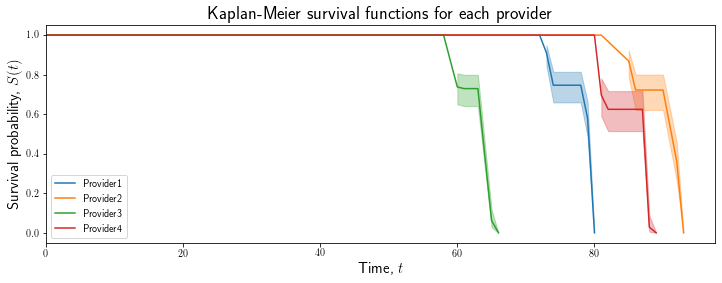

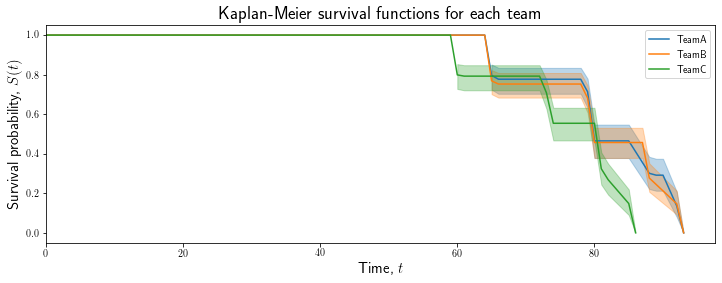

In [43]:
for feat in ['provider', 'team']:
    # Initialize the figure
    fig, ax = plt.subplots(figsize=(12., 4.))

    # Loop through each provider
    for idx, feat_item in enumerate(sorted(raw_dataset[feat].unique())):

        # Filter the dataset for specific provider
        reduced_dataset = raw_dataset[raw_dataset[feat] == feat_item]

        # Initialize the Kaplan-Meier model
        km_item = KaplanMeierFitter()

        # Fit the model
        km_item.fit(
            reduced_dataset[time_column],
            event_observed=reduced_dataset[event_column],
        )

        # Plot survival function
        ax.plot(
            km_item.timeline,
            km_item.survival_function_.to_numpy().flatten(),
            label=feat_item,
            color=colors[idx],
        )

        # Plot confidence interval
        ax.fill_between(
            km_item.timeline,
            km_item.confidence_interval_['KM_estimate_lower_0.95'].to_numpy(),
            km_item.confidence_interval_['KM_estimate_upper_0.95'].to_numpy(),
            alpha=.3,
            color=colors[idx],
        )

    ax.set_title(
        'Kaplan-Meier survival functions for each {}'.format(feat),
        fontsize=18.,
    )
    ax.set_xlabel(
        'Time, $ t $',
        fontsize=15.,
    )
    ax.set_ylabel(
        'Survival probability, $ S(t) $',
        fontsize=15.,
    )
    ax.set_xlim(0., None)
    ax.set_ylim(-.05, 1.05)
    ax.legend()
    plt.show()

### 6.1b [Nelson-Aalen](https://en.wikipedia.org/wiki/Nelson%E2%80%93Aalen_estimator) model

Let's now fit a Nelson-Aalen model to the training set. This will give us population-based average cumulative hazard behaviour.

Let's start by importing the `NelsonAalenFitter` estimator from the `lifelines` library.

In [44]:
# Import estimator
from lifelines import NelsonAalenFitter

In [45]:
# Initialize the Nelson-Aalen model
na = NelsonAalenFitter()

In [46]:
# Fit the model
na.fit(
    dataset[time_column],
    event_observed=dataset[event_column],
)

<lifelines.NelsonAalenFitter: fitted with 1000 total observations, 603 right-censored observations>

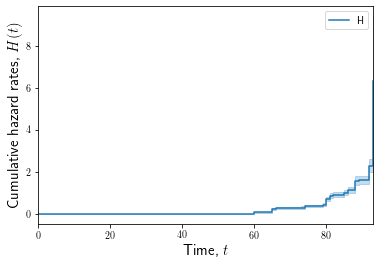

In [47]:
# Display survival function
ax = na.plot(label='H')
ax.set_xlabel(
    'Time, $ t $',
    fontsize=15.,
)
ax.set_ylabel(
    'Cumulative hazard rates, $ H(t) $',
    fontsize=15.,
)
plt.legend()
plt.show()

We can have access to all the number of observations for the timeline through `event_table` attribute.

In [48]:
# Check event table
na.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,1000,1000
1.0,5,0,5,0,1000
2.0,11,0,11,0,995
3.0,3,0,3,0,984
4.0,8,0,8,0,981
...,...,...,...,...,...
88.0,46,42,4,0,112
89.0,1,1,0,0,66
90.0,1,0,1,0,65


We can also derive the hazard function $ h(t) $ from the computed cumulative hazard function $ H(t) $.

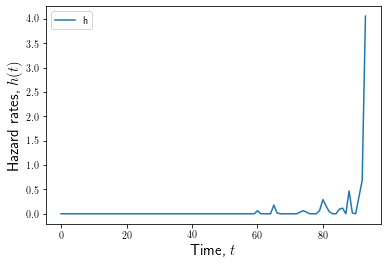

In [49]:
# Get cumulative hazard function
H = na.cumulative_hazard_.to_numpy().flatten()

# Calculate hazard function
h = H.copy()
h[1:] -= h[:-1]

# Plot hazard function
plt.plot(
    na.timeline,
    h,
    label='h',
)
plt.xlabel(
    'Time, $ t $',
    fontsize=15.,
)
plt.ylabel(
    'Hazard rates, $ h(t) $',
    fontsize=15.,
)
plt.legend()
plt.show()

We can also compare survival function estimated using Kaplan-Meier estimator with the derived survival function from the estimated cumulative hazard function using Nelson-Aalen estimator. Let's plot them to see if they match.

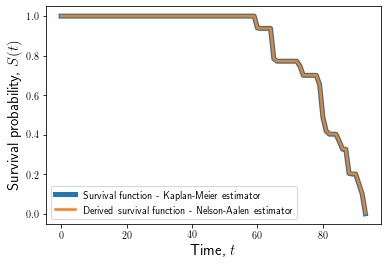

In [50]:
# Get KM survival function
S = km.survival_function_.to_numpy().flatten()

# Derive survival function from NA estimate
S_na = np.exp(-H)

# Plot
plt.plot(
    km.timeline,
    S,
    lw=5.,
    label='Survival function - Kaplan-Meier estimator',
    color=colors[0],
)

plt.plot(
    na.timeline,
    S_na,
    lw=2.5,
    label='Derived survival function - Nelson-Aalen estimator',
    color=colors[1],
)

plt.xlabel(
    'Time, $ t $',
    fontsize=15.,
)
plt.ylabel(
    'Survival probability, $ S(t) $',
    fontsize=15.,
)
plt.legend()
plt.show()

### 6.2. [Cox Proportional Hazards](https://en.wikipedia.org/wiki/Proportional_hazards_model) model

To account for the effect of covariates on the output functions, the Cox proportional hazards model (CPH) is typically used for survival regression. It is a semi-parametric regression model that estimates the risk, i.e. the log of the hazard rate, of an event occurring as a linear combination of the covariates as $ \beta^{\mathsf{T}} \mathrm{\mathbf{x}} $, with $ \beta $ being a vector of coefficients and $ \mathrm{\mathbf{x}} $ denoting a vector of time-constant covariates. It maximizes the Cox's partial likelihood function (of the coefficients):

$$ L(\beta) = \prod_{i: E_i = 1} \frac{h_i}{\sum_{j: T_j \ge T_i} h_j} = \prod_{i: E_i = 1} \frac{\exp \left( \beta^{\mathsf{T}} \mathrm{\mathbf{x}}_i \right)}{\sum_{j: T_j \ge T_i} \exp \left( \beta^{\mathsf{T}} \mathrm{\mathbf{x}}_j \right)} $$

where only uncensored data ($ i: E_i = 1 $) are used (hence the term "partial"). The corresponding negative log-likelihood function for minimization is given below.

$$ l(\beta) = - \log L(\beta) = - \sum_{i: E_i = 1} \left( \beta^{\mathsf{T}} \mathrm{\mathbf{x}}_i - \log \sum_{j: T_j \ge T_i} \exp \left( \beta^{\mathsf{T}} \mathrm{\mathbf{x}}_j \right) \right) $$

The hazard function is computed for each individual as a product of the population-level time-dependent baseline hazard $ h_0(t) $ and the individual-level time-constant partial hazard expressed through the exponent of a linear combination of the covariates. It is formulated as:

$$ h(t \vert \mathrm{\mathbf{x}}) = h_0(t) \exp \left( \beta^{\mathsf{T}} \mathrm{\mathbf{x}} \right) $$

All individuals share the same baseline hazard, and the effect of covariates acts as a scaler through the partial hazard. The baseline hazard function is estimated using the Breslow method. The exponential form ensures that the hazard rates are always positive. The ratio of the hazard functions of two individuals is always constant and it is given by the ratio of their partial hazards (hence the term "proportional"). Given the hazard function, cumulative hazard function and survival function can be computed using previously defined equations.

Let's now fit a Cox Proportional Hazards (CPH) model to the training set. This is a linear model that can give us a baseline for individual predictions, that we can later use to compare with more advanced models.

Lest's start by importing the `CoxPHFitter` estimator from the `lifelines` library.

In [51]:
# Import estimator
from lifelines import CoxPHFitter

In [52]:
# Initialize the Cox Proportional Hazards model
cph = CoxPHFitter(penalizer=.1)

In [53]:
# Fit the model: : https://lifelines.readthedocs.io/en/latest/lifelines.fitters.html#lifelines.fitters.coxph_fitter.CoxPHFitter.fit
cph.fit(
    data_train,
    duration_col=time_column,
    event_col=event_column,
    show_progress=True,
)

Iteration 10: norm_delta = 0.00000, step_size = 1.0000, ll = -776.93532, newton_decrement = 0.00000, seconds_since_start = 0.0Convergence completed after 10 iterations.


<lifelines.CoxPHFitter: fitted with 700 total observations, 412 right-censored observations>

In [54]:
# Print estimation summary
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 700 total observations, 412 right-censored observations>
             duration col = 'lifetime'
                event col = 'broken'
                penalizer = 0.1
   number of observations = 700
number of events observed = 288
   partial log-likelihood = -776.94
         time fit was run = 2019-11-24 15:08:55 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
pressureInd          0.05       1.05       0.06            -0.07             0.17                 0.93                 1.18
moistureInd         -0.13       0.87       0.06            -0.26            -0.01                 0.77                 0.99
temperatureInd       0.47       1.60       0.07             0.34             0.60                 1.40                 1.83
provider_Provider2  -9.38       0.00       0.95           -11.23            -7.53                 0.00                 0.00
provider_Provider3   7

Let's calculate C-index for training and test data. Remember that we need to use only uncensored observations.

In [55]:
# Concordance index for the training data
c_index_train = concordance_index(
    data_train[time_column][E_train.astype(bool)],
    cph.predict_expectation(data_train)[E_train.astype(bool)],
)

print('C-index (training) = {}'.format(np.round(c_index_train, 2)))

C-index (training) = 1.0


In [56]:
# Concordance index for the test data
c_index_test = concordance_index(
    data_test[time_column][E_test.astype(bool)],
    cph.predict_expectation(data_test)[E_test.astype(bool)],
)

print('C-index (test) = {}'.format(np.round(c_index_test, 2)))

C-index (test) = 1.0


Let's now calculate and plot Brier scores for training and test data for the each instant from the timeline.

In [57]:
# Calculate Brier scores for the timeline
brier_scores = []

for X, T in [
    (
        data_train[features][E_train.astype(bool)],
        data_train[time_column][E_train.astype(bool)],
    ),
    (
        data_test[features][E_test.astype(bool)],
        data_test[time_column][E_test.astype(bool)],
    )]:
    
    brier_score = []

    predictions = cph.predict_survival_function(X)
    timeline = predictions.index.to_numpy()

    for t in predictions.index:
        survival = predictions.loc[t]

        y_true_brier = np.array(t < T, dtype=float)

        brier_score.append(brier_score_loss(y_true_brier, survival))
    
    brier_scores.append(np.array(brier_score))

Integrated Brier score (training) = 0.003
Integrated Brier score (test) = 0.004


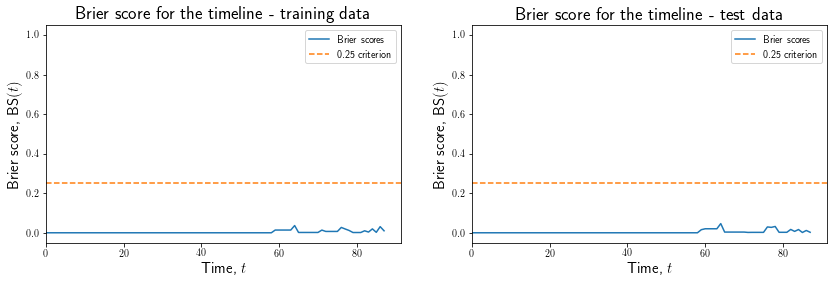

In [58]:
# Plot Brier scores
fig = plt.figure(figsize=(14., 4.))

for idx, score in enumerate(brier_scores):
    ax = fig.add_subplot(1, 2, idx + 1)
    
    label = 'training' if idx == 0 else 'test'
    
    ax.plot(
        score,
        color=colors[0],
        label='Brier scores'
    )
    ax.axhline(
        0.25, 
        color=colors[1], 
        ls='--',
        label='0.25 criterion',
    )
    ax.set_xlim(0., None)
    ax.set_ylim(-.05, 1.05)
    ax.set_title(
        'Brier score for the timeline - {} data'.format(label),
        fontsize=18.,
    )
    ax.set_xlabel(
        'Time, $ t $',
        fontsize=15.,
    )
    ax.set_ylabel(
        'Brier score, BS$ (t) $',
        fontsize=15.,
    )
    ax.legend()
    
    print('Integrated Brier score ({}) = {}'.format(label, np.round(score.mean(), 3)))

plt.show()

It seems that our model performs quite good, with all the values way below the 0.25 criterion!

---

## <span style="color:#3498DB">7. Predictions</span>

### 7.1. Overall predictions

Let's compare the baseline survival function obtained via the Kaplan-Meier estimator and the average prediction of the Cox proportional hazard models.

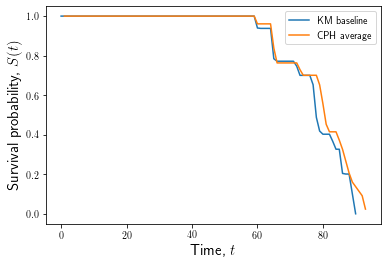

In [59]:
# Compare the baseline survival function obtained via Kaplan-Meier estimator and 
# the average prediction of the Cox proportional hazard models

plt.plot(
    S,
    label='KM baseline',
    color=colors[0],
)

plt.plot(
    cph.predict_survival_function(X_test).mean(axis=1),
    label='CPH average',
    color=colors[1],
)

plt.xlabel(
    'Time, $ t $',
    fontsize=15.,
)
plt.ylabel(
    'Survival probability, $ S(t) $',
    fontsize=15.,
)
plt.legend()
plt.show()

It's not bad, but it probably could be better with some more sofisticated models (remember that CPH assumes a linear relation among the features).

Now, instead of comparing total average curves, let's be more specific and do what we did above for each provider separately, but also calculate average CPH functions for each provider and compare them with the baseline models.

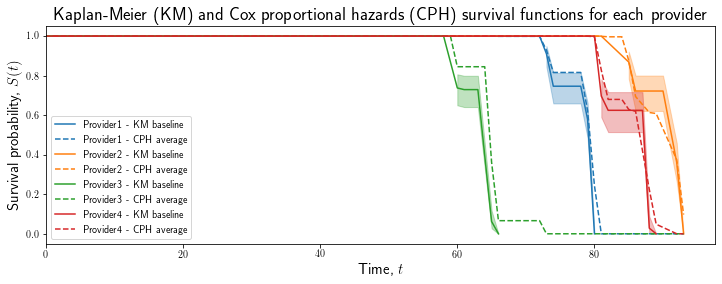

In [60]:
# Initialize the figure
fig, ax = plt.subplots(figsize=(12., 4.))

# Loop through each provider
for idx, provider in enumerate(sorted(raw_dataset['provider'].unique())):
    
    # Filter the dataset for specific provider
    reduced_dataset = raw_dataset[raw_dataset['provider'] == provider]
    
    # ***** Kaplan-Meier models *****
    
    # Initialize the Kaplan-Meier model
    km_provider = KaplanMeierFitter()
    
    # Fit the model
    km_provider.fit(
        reduced_dataset[time_column],
        event_observed=reduced_dataset[event_column],
    )
    
    # Plot KM survival function
    ax.plot(
        km_provider.timeline,
        km_provider.survival_function_.to_numpy().flatten(),
        label='{} - KM baseline'.format(provider),
        color=colors[idx],
    )
    
    # Plot KM confidence interval
    ax.fill_between(
        km_provider.timeline,
        km_provider.confidence_interval_['KM_estimate_lower_0.95'].to_numpy(),
        km_provider.confidence_interval_['KM_estimate_upper_0.95'].to_numpy(),
        alpha=.3,
        color=colors[idx],
    )
    
    # ***** Cox proportional hazards models predictions *****
    
    indexes = np.intersect1d(reduced_dataset.index.to_numpy(), index_test)
    predictions = cph.predict_survival_function(X_test.loc[indexes])
    
    # Plot CPH survival function
    ax.plot(
        predictions.index.to_numpy(),
        predictions.mean(axis=1),
        label='{} - CPH average'.format(provider),
        ls='--',
        color=colors[idx],
    )

ax.set_title(
    'Kaplan-Meier (KM) and Cox proportional hazards (CPH) survival functions for each provider',
    fontsize=18.,
)
ax.set_xlabel(
    'Time, $ t $',
    fontsize=15.,
)
ax.set_ylabel(
    'Survival probability, $ S(t) $',
    fontsize=15.,
)
ax.set_xlim(0., None)
ax.set_ylim(-.05, 1.05)
ax.legend()
plt.show()

Comparisons show that the model does an excellent job predicting the number of machines that are still working or that failed for all times $ t $. Therefore, we will use it also to do individual predictions.

### 7.2. Individual predictions

Now that we know that we can provide reliable predictions for an entire cohort, let's compute the survival predictions at the individual level.

We need to construct the risk groups based on [risk scores](https://square.github.io/pysurvival/math.html) distribution. The faster you experience the event, the higher your risk score is. It is computed as (note that the log function is not mandatory):

$$ r(\mathrm{\mathbf{x}}) = \log \left( \sum_{t = 1}^{T_{max}} H \left( t_j, \mathrm{\mathbf{x}} \right) \right) $$

Let's calculate the risk scores for our test data, using the above formula.

In [61]:
# Predict cumulative hazard function for each sample from the test data
H_pred = [cph.predict_cumulative_hazard(X_test.iloc[i]).to_numpy().flatten() for i in range(X_test.shape[0])]
# Another way to compute H_pred (more efficient)
# H_pred = list(data_test[features].apply(lambda x: cph.predict_cumulative_hazard(x).to_numpy().flatten().tolist(), axis=1))

# Convert list to NumPy array
H_pred = np.array(H_pred)

# Sum the values over the timeline
r = H_pred.sum(axis=1)

# Apply log transform
r = np.log(r)

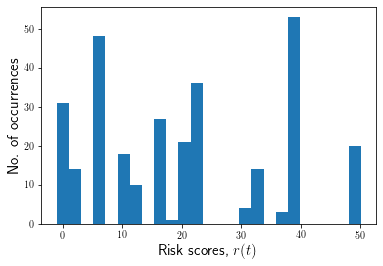

In [62]:
# Plot risk groups
plt.hist(
    r,
    bins=25,
    color=colors[0],
)
plt.xlabel(
    'Risk scores, $ r(t) $',
    fontsize=15.,
)
plt.ylabel(
    'No. of occurrences',
    fontsize=15.,
)
plt.show()

In [63]:
# Define risk group based on the histogram above
risk_groups_def = {
    'low': {
        'lower_bound': -1.,
        'upper_bound': 11.,
        'color': 0,
    },
    'medium': {
        'lower_bound': 11.,
        'upper_bound': 22.,
        'color': 1,
    },
    'high': {
        'lower_bound': 22.,
        'upper_bound': 51.,
        'color': 2,
    },
}

*Note: The current choice of the lower and upper bounds for each group is based on my intuition; so feel free to change the values so as to match your situation instead.*

Here, we can see that 3 main groups, **low**, **medium** and **high** risk groups, can be created. Because the C-index is high, the model will be able to perfectly rank the survival times of a random unit of each group, such that $ t_{high} \leq t_{medium} \leq t_{low} $.

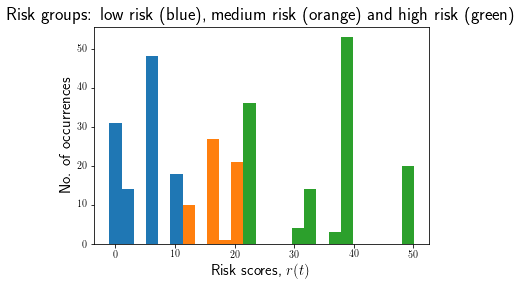

In [64]:
# Plot risk groups with color
n, bins, patches = plt.hist(
    r,
    bins=25,
)

# Get centers of the bins
bin_centers = .5 * (bins[:-1] + bins[1:])

risk_colors = []

# Claculate color for each bar based on the define criteria
for i in bin_centers:
    for k in risk_groups_def.keys():
        if risk_groups_def[k]['lower_bound'] < i <= risk_groups_def[k]['upper_bound']:
            color = colors[risk_groups_def[k]['color']]
            risk_colors.append(color)

# Change bar colors
for color, patch in zip(risk_colors, patches):
    plt.setp(
        patch,
        'facecolor',
        color,
    )

plt.title(
    'Risk groups: low risk (blue), medium risk (orange) and high risk (green)',
    fontsize=18.,
)
plt.xlabel(
    'Risk scores, $ r(t) $',
    fontsize=15.,
)
plt.ylabel(
    'No. of occurrences',
    fontsize=15.,
)
plt.show()

Let's now assign each sample to a corresponding risk group.

In [65]:
# Assign each sample to a corresponding risk group
risk_groups = {}

for k in risk_groups_def.keys():
    risk_groups[k] = []

for i in range(len(r)):
    for k in risk_groups_def.keys():
        if risk_groups_def[k]['lower_bound'] < r[i] <= risk_groups_def[k]['upper_bound']:
            risk_groups[k].append(i)
            continue

Let's randomly select individual unit in each group and compare the survival functions. To demonstrate our point, we will purposely select units which experienced an event to visualize the actual time of event.

As it randomly chooses samples, we can run the following code multiple times and observe what happens with the output - how good are our predictions?

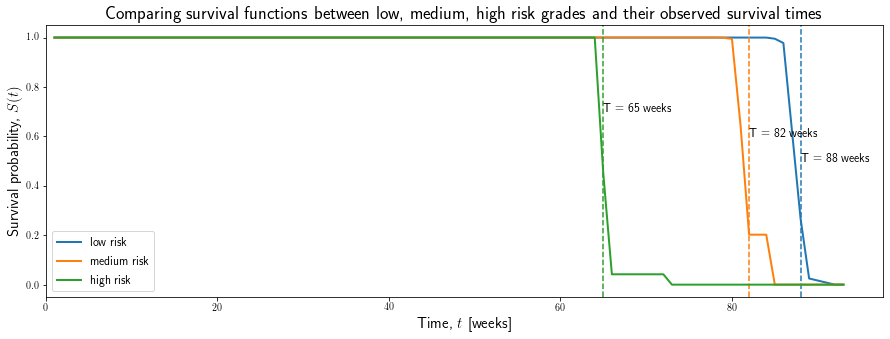

In [66]:
# Plot predicted survival functions and actual obseved survial times for one sample from each risk group

# Initialize the figure
fig, ax = plt.subplots(figsize=(15., 5.))

# Select a random individual that experienced an event from each group
for i, (label, indexes) in enumerate(risk_groups.items()):
    color = colors[risk_groups_def[label]['color']]
    
    # Select the individuals that belong to this group
    if len(indexes) == 0:
        continue
    X = X_test.iloc[indexes]
    T = T_test.to_numpy()[indexes]
    E = E_test.to_numpy()[indexes]
    
    # Randomly extract an individual that experienced an event
    choices = np.argwhere((E == 1.)).flatten()
    if len(choices) == 0:
        continue
    k = np.random.choice(choices, 1)[0]
    
    # Save the time of event
    t = T[k]
    
    # Compute the survival function for all times t
    prediction = cph.predict_survival_function(X[k:k + 1])
    survival = prediction.to_numpy().flatten()
    timeline = prediction.index.to_numpy()
    
    # Display the functions
    label = '{} risk'.format(label)
    ax.plot(
        timeline,
        survival,
        color=color,
        label=label,
        lw=2.,
    )

    # Actual time
    ax.axvline(
        x=t,
        color=color,
        ls='--',
    )
    ax.annotate(
        'T = {:.0f} weeks'.format(t),
        xy=(t, .5 * (1. + .2 * i)),
        xytext=(t, .5 * (1. + .2 * i)),
        fontsize=12.,
    )

# Show everything
groups_str = ', '.join(risk_groups_def.keys())
ax.set_title(
    'Comparing survival functions between {} risk grades and their observed survival times'.format(groups_str),
    fontsize=18.,
)
ax.set_xlabel(
    'Time, $ t $ [weeks]',
    fontsize=15.,
)
ax.set_ylabel(
    'Survival probability, $ S(t) $',
    fontsize=15.,
)
ax.set_xlim(0., None)
ax.set_ylim(-.05, 1.05)
ax.legend(fontsize=12.)
plt.show()

Not bad at all, right? As we can see, the model manages to perfectly predict the event time, here it corresponds to a sudden drop in the individual survival function.

---

## <span style="color:#3498DB">8. Conclusion</span>

In this example, we have shown that it is possible to predict with great degree of certainty when a machine will fail. The Data Science team could predict the machines survival function every day, so that 1 or 2 weeks before the machine is supposed to fail, the factory manager is notified so that the necessary actions can be taken.

We can now save our model so as to put it in production and score future machines.

In [67]:
# Model path
model_path = '/Users/boko/Desktop/cph_model.pkl'

# Open a file, where you want to store the data
file = open(model_path, 'wb')

# Dump information to that file
pickle.dump(cph, file)

# Close the file
file.close()

To use the previously saved model, we just need to load it and start making predictions!

In [68]:
# Model path
model_path = '/Users/boko/Desktop/cph_model.pkl'

# Open a file, where you want to store the data
file = open(model_path, 'rb')

# Load information from the file
cph_loaded = pickle.load(file)

# Close the file
file.close()

# Check variable
cph_loaded

<lifelines.CoxPHFitter: fitted with 700 total observations, 412 right-censored observations>

---

## <span style="color:#3498DB">References</span>

* https://lifelines.readthedocs.io/en/latest
* https://square.github.io/pysurvival/tutorials/maintenance.html
* https://en.wikipedia.org/wiki/Predictive_maintenance
* [Essec Business School - Course in Business Analytics](https://www.essec.edu/en/)
* [Maintenance dataset](https://github.com/ludovicbenistant/Management-Analytics/blob/master/Supply%20Chain/Maintenance%20(survival%20analysis)/maintenance_data.csv)
* https://github.com/nicolasfguillaume/Strategic-Business-Analytics-with-R/blob/master/module4.md